# Models
In this notebook we will generate several different models using the already engineered features. We will then evaluate the models using cross validation and select the best model to use for our predictions.

In [30]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [31]:
GEO = 'texas'
df = pd.read_csv(f'../../data/processed/features_{GEO}.csv')
df.index = df["review_id"]
df.drop(columns=["review_id"], inplace=True)

print(df.shape)
df.head()

(978, 4)


,tsne_0,tsne_1,tsne_2,label
review_id,,,,
83097,-0.64,-4.60,-1.69,good
133337,-6.71,4.31,-0.53,good
150928,-1.12,-5.46,2.87,good
2706775,-5.98,-5.60,-0.02,good
8602878,1.93,-3.28,-1.66,good


In [32]:
df.label.value_counts()

good     813
mbad      72
mgood     64
bad       29
Name: label, dtype: int64

The data is extremely imbalanced. We can use the `imbalanced-learn` Python library, which has several implementations of resampling methods to deal with this problem. We will use the `SMOTE` method, which oversamples the minority class.

In [33]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, y = oversample.fit_resample(df.drop(columns=["label"]), df["label"])

print("Balanced labels:")
y.value_counts()

Balanced labels:


good     813
mgood    813
mbad     813
bad      813
Name: label, dtype: int64

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (2601, 3)
Test shape: (651, 3)


Use lazy predict to compare base models

In [46]:
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models.sort_values(by="Accuracy", ascending=False).head(10)

100%|██████████| 29/29 [00:02<00:00, 10.20it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.87,0.87,None,0.87,0.26
RandomForestClassifier,0.86,0.86,None,0.86,0.46
LGBMClassifier,0.83,0.84,None,0.83,0.24
BaggingClassifier,0.83,0.83,None,0.82,0.09
KNeighborsClassifier,0.80,0.81,None,0.80,0.02
DecisionTreeClassifier,0.77,0.78,None,0.77,0.02
LabelPropagation,0.77,0.78,None,0.77,0.14
LabelSpreading,0.77,0.78,None,0.76,0.19
ExtraTreeClassifier,0.72,0.73,None,0.72,0.02


Tune hyperparamters of SVC (Support Vector Classifier)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters:
{'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score:
0.843139672227964
Accuracy: 0.8602150537634409


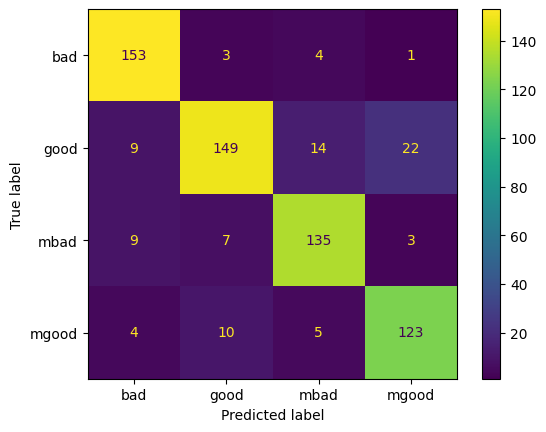

In [42]:
# load ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier

# apply GridSearchCV to find the best parameters
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['auto', 'sqrt', 'log2'],
}

clf = GridSearchCV(ExtraTreesClassifier(), params, cv=5, n_jobs=-1, verbose=1)
clf.fit(X_train, y_train)
best_clf = clf.best_estimator_

# print the best parameters
print("Best parameters:")
print(clf.best_params_)
print("Best Score:")
print(clf.best_score_)

# predict
y_pred = best_clf.predict(X_test)

# evaluate
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Accuracy:", accuracy_score(y_test, y_pred))

# plot a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

